# Multiview Hand Pose CNN

Author: **Mattia Orlandi**

In this notebook, I train the MultiViewHandPoseCNN model from [Ge et al.](https://arxiv.org/abs/1606.07253) (2016) for 3D hand pose estimation on the [MSRA dataset](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Sun_Cascaded_Hand_Pose_2015_CVPR_paper.pdf) (2015).

## 0. Environment Setup
The necessary libraries are imported: in particular, PyTorch is chosen as deep learning framework. CUDA acceleration, if available, is enabled.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# System packages
import os
import sys
import glob
import struct
import random
from time import time

# Data and numerical management packages
import numpy as np
import pandas as pd

# DL tools
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# 2D and 3D data visualization tools
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Other tools
from tqdm.notebook import tqdm

# Custom modules
from multiview_hand_pose_cnn.dataset.msra_dataset import MSRADataset, ToPointCloud, ToTensor

# Type hint
from typing import Tuple, List, Dict, Optional, Union

Turn on CUDA acceleration for PyTorch, if available.

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print('CUDA acceleration available and enabled.')
else:
    DEVICE = torch.device('cpu')
    print('CUDA acceleration not available.')

CUDA acceleration available and enabled.


Ensure reproducibility by enabling deterministic behaviour and fixing the seed.

In [4]:
def fix_reproducibility(seed: int):
    """Set the deterministic behaviour in PyTorch and fix seed.
        :param seed: the seed to fix reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_reproducibility(SEED)

The principal point and the focal length of the camera used in the MSRA dataset are set according to [the official instructions](https://jimmysuen.github.io/txt/cvpr15_MSRAHandGestureDB_readme.txt).

In [5]:
MSRA_CAMERA_PARAMS = {'principal_point': (160, 120), 
                      'focal_length': 241.42}

## 1. Dataset preparation
A custom `Dataset` object to load and handle MSRA dataset was defined in `multiview_hand_pose_cnn.dataset.msra_dataset` module, together with two transforms that:
- turn the depth image into a point cloud;
- turn a NumPy's array in a PyTorch's tensor.

In [6]:
to_point_cloud_tfsm = ToPointCloud(MSRA_CAMERA_PARAMS)
msra_dataset = MSRADataset(root_folder='msra_dataset', transforms=[to_point_cloud_tfsm])

## 2. Data visualization
A utility function to plot the point clouds is defined.

In [7]:
def plot_point_cloud(point_cloud: Tuple[np.ndarray, Dict[str, Tuple[float, float, float]]], 
                     ax: plt.Axes, title: str,
                     plot_joints: Optional[bool] = False,
                     elev: Optional[float] = 10,
                     azim: Optional[float] = -45):
    """Function that plots a single point cloud in 3D space using mplot3d.
        :param point_cloud: tuple ('point_cloud', 'joints'), where 'point cloud' is a (rows, cols, 3) NumPy's array,
                            and 'joints' is a dictionary with the mapping between joints and 3D coordinates;
        :param ax: PyPlot's Axes object in which the point cloud will be plotted;
        :param title: the title of the plot;
        :param plot_joints: boolean flag indicating whether to plot joints or not (False by default).
        :param elev: elevation angle (10 by default);
        :param azim: azimut angle (-45 by default)."""
    # Flatten first two dimensions
    flat_pc = point_cloud[0].reshape(-1, 3)
    joints = point_cloud[1]
    
    # Compute boundaries (N.B. to better represent the 3D point cloud, y's sign is inverted, while y and z are swapped)
    xlim = (min(flat_pc[:, 0]) - 1, max(flat_pc[:, 0]) + 1)
    ylim = (min(flat_pc[:, 2]) - 1, max(flat_pc[:, 2]) + 1)
    zlim = (min(-flat_pc[:, 1]) - 1, max(-flat_pc[:, 1]) + 1)
    # Set title, boundaries and view's angle
    ax.title.set_text(title)
    ax.set_xlim3d(*xlim)
    ax.set_ylim3d(*ylim)
    ax.set_zlim3d(*zlim)
    ax.elev = elev
    ax.azim = azim
    # Scatter plot the point cloud
    ax.scatter(xs=flat_pc[:, 0], ys=flat_pc[:, 2], zs=-flat_pc[:, 1], s=1, c='orange')
    # Scatter plot the joints, if required
    if plot_joints:
        for joint, coords in joints.items():
            ax.scatter(xs=coords[0], ys=coords[2], zs=-coords[1], s=20, label=joint)
        ax.legend()
    

def plot_point_clouds(point_clouds: List[Tuple[np.ndarray, Dict[str, Tuple[float, float, float]]]],
                      plot_joints: Optional[bool] = False):
    """Function that plots a list of point clouds by iteratively calling plot_point_cloud().
        :param point_clouds: list of tuples ('point_cloud', 'joints'), where 'point cloud' is a (rows, cols, 3) NumPy's array,
                             and 'joints' is a dictionary with the mapping between joints and 3D coordinates;
        :param plot_joints: boolean flag indicating whether to plot joints or not (False by default)."""
    fig = plt.figure(figsize=(20, 20))
    # Compute number of rows and cols of subplots
    n_pcs = len(point_clouds)
    n_cols = 4
    n_rows = n_pcs // n_cols + 1
    
    for i, point_cloud in enumerate(tqdm(point_clouds, leave=False)):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')
        plot_point_cloud(point_cloud, ax, title=f'PC{i + 1}', plot_joints=plot_joints)
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        plt.setp(ax.get_yticklabels(), rotation=-30, horizontalalignment='right')
    fig.tight_layout()

For example, let's plot the point clouds associated with all the hand poses of subject P0.

  0%|          | 0/18 [00:00<?, ?it/s]

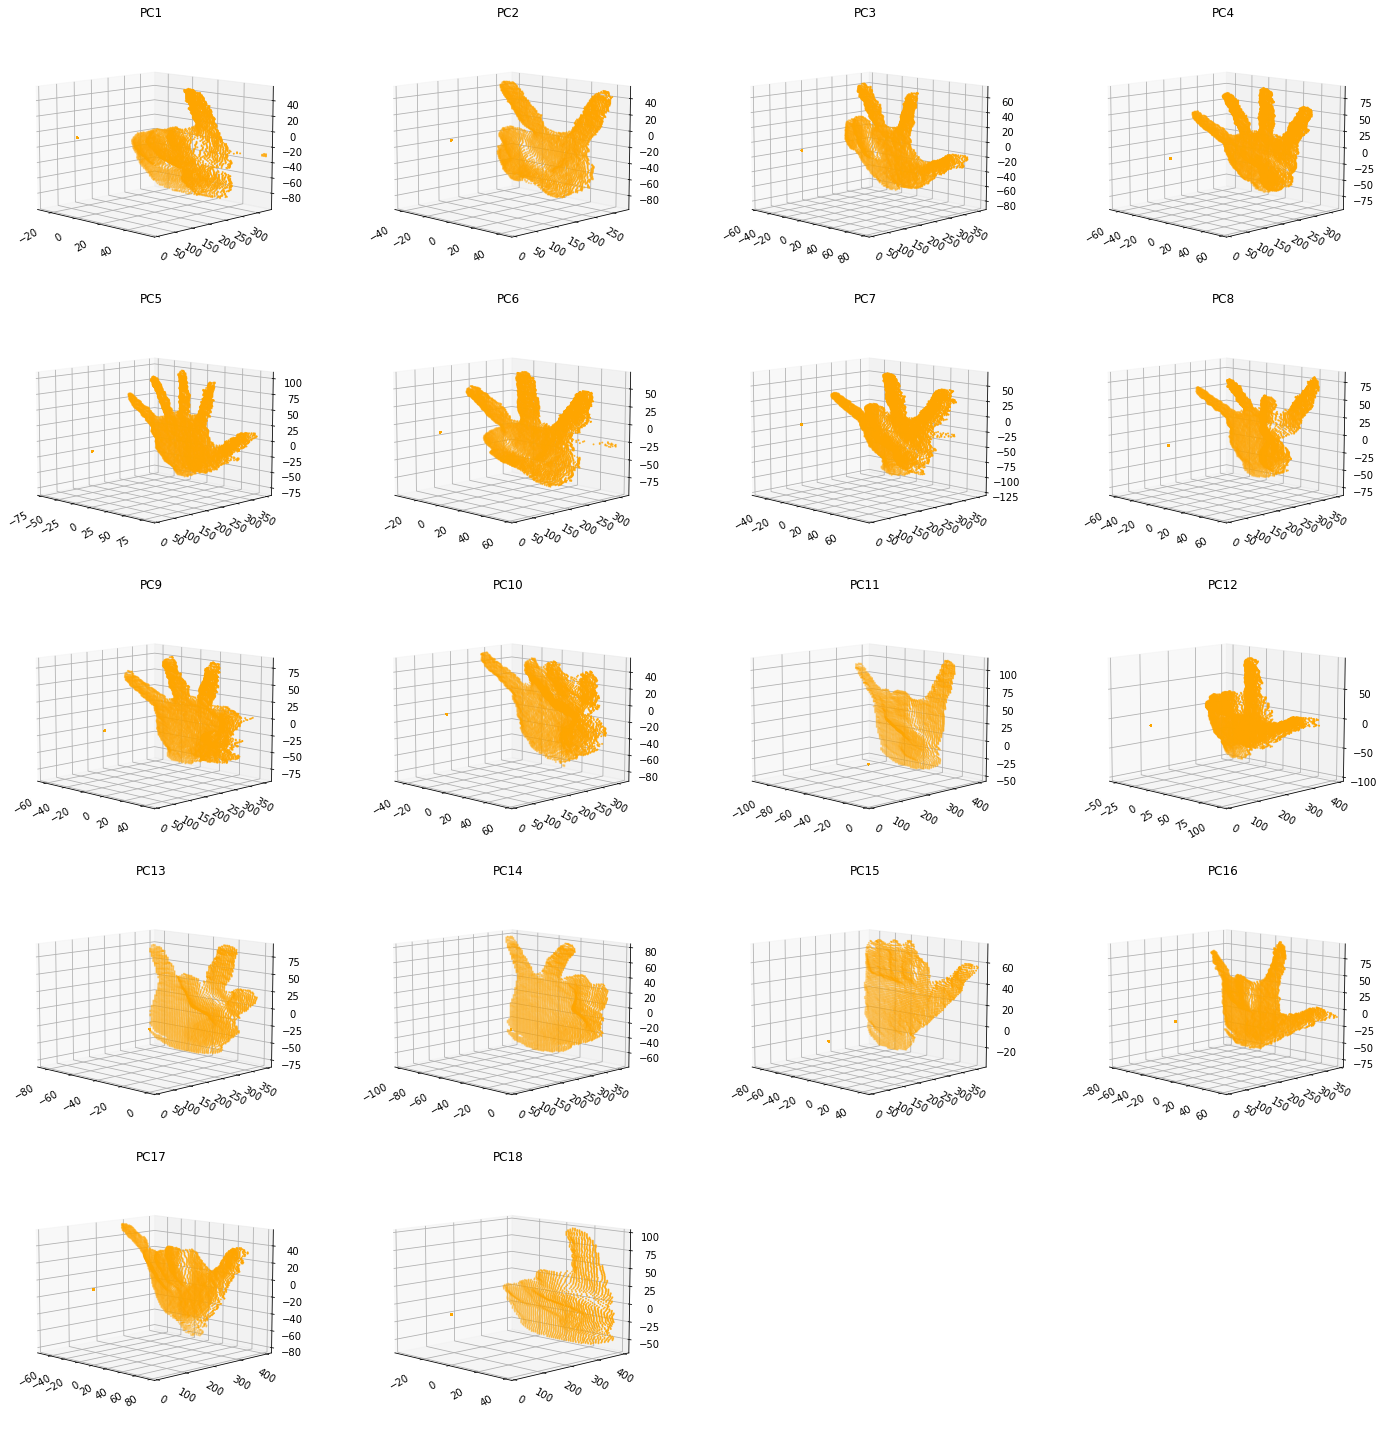

In [8]:
samples = [msra_dataset[idx * 500] for idx in range(18)]
plot_point_clouds(samples)

Then, let's plot the first point cloud together with the joints' coordinates.

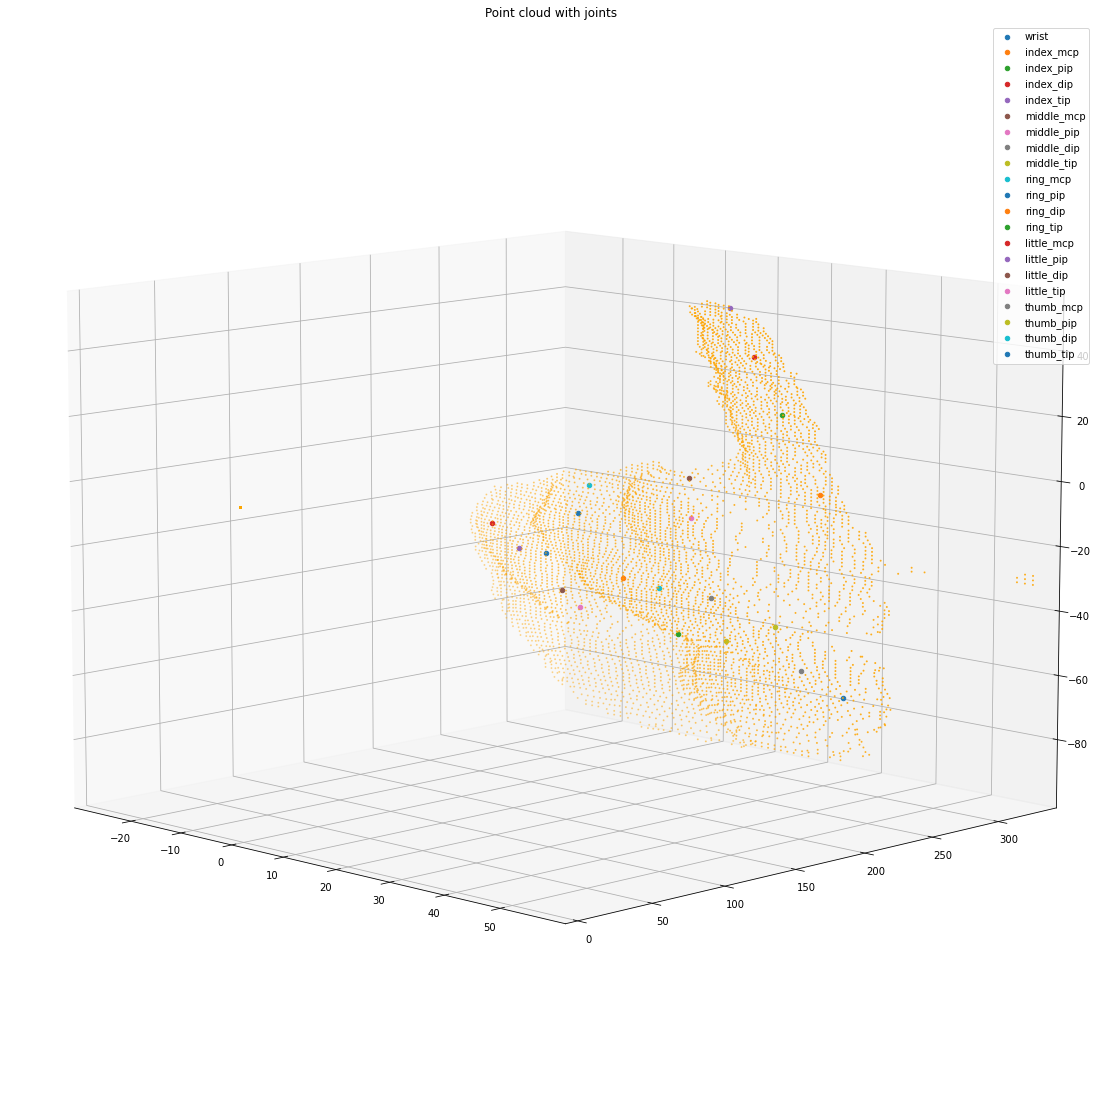

In [9]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_point_cloud(msra_dataset[0], ax, 'Point cloud with joints', plot_joints=True)

Moreover, a function to plot the 3 orthogonal projections of a point cloud is defined.

In [10]:
def project_point_cloud(point_cloud: Tuple[np.ndarray, Dict[str, Tuple[float, float, float]]]):
    fig = plt.figure(figsize=(20, 20))
    proj_dict = {'XY': 2, 'XZ': 1, 'YZ': 0}
    
    for i, p in enumerate(proj_dict.keys()):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        # Create copy of point cloud and set target dimension to zero
        (point_cloud_data, joints) = point_cloud
        proj_shape = (point_cloud_data.shape[0], point_cloud_data.shape[1])
        point_cloud_proj = point_cloud_data.copy()
        point_cloud_proj[:, :, proj_dict[p]] = np.zeros(proj_shape)
        # Plot projected point cloud
        plot_point_cloud((point_cloud_proj, joints), ax, title=f'{p} projection', elev=30)
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        plt.setp(ax.get_yticklabels(), rotation=-30, horizontalalignment='right')
    fig.tight_layout()

For instance, the projection of the first point cloud associated to hand pose 1 and subject P0 is the following.

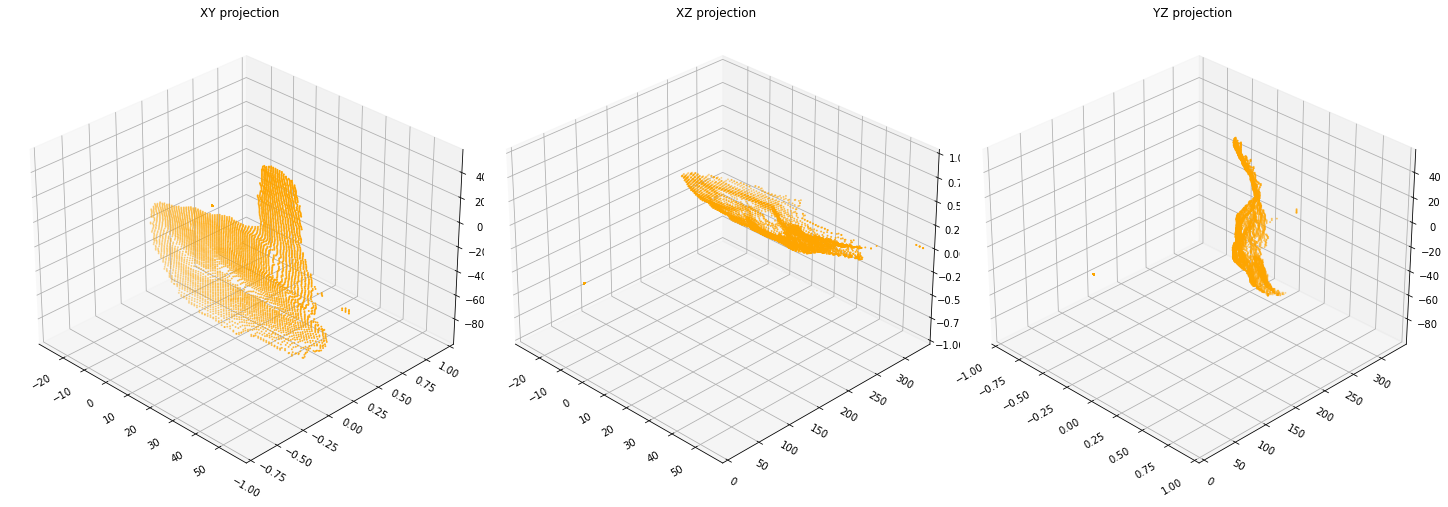

In [12]:
project_point_cloud(msra_dataset[0])

## 3. MultiviewHandPoseCNN model
The `MultiviewHandPoseCNN` model, defined in `multiview_hand_pose_cnn.nn.multiview_hand_pose_cnn` module, is instantiated.

In [ ]:
# TODO

## 4. Training
Before actually training the model, `ToTensor` transform is added to the dataset.

In [13]:
to_tensor = ToTensor()
msra_dataset.add_transform(to_tensor)

Then, the dataset is split in training, validation and test sets.

In [14]:
SPLIT_SIZE = 0.2

# Shuffle indices and split them: the first 20% are reserved for test, the next 20% for validation, and the remaining 60% for training
indices = list(range(len(msra_dataset)))
test_split = int(np.floor(SPLIT_SIZE * len(msra_dataset)))
val_split = test_split + int(np.floor(SPLIT_SIZE * len(msra_dataset)))
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[val_split:], indices[test_split:val_split], indices[:test_split]

# Create Sampler objects
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

Then, the `DataLoader` objects are created.

In [16]:
EP = 100
BS = 32
WORKERS = 4

train_loader = DataLoader(msra_dataset, batch_size=BS,
                          sampler=train_sampler, num_workers=WORKERS,
                          pin_memory=True)
val_loader = DataLoader(msra_dataset, batch_size=BS,
                        sampler=val_sampler, num_workers=WORKERS,
                        pin_memory=True)
test_loader = DataLoader(msra_dataset, batch_size=BS,
                         sampler=test_sampler, num_workers=WORKERS,
                         pin_memory=True)

In [17]:
for ep in range(EP):
    for batch_idx, (batch_pc, batch_joints) in enumerate(train_loader):
        print(batch_pc.shape)
        break
    break

torch.Size([32, 240, 320, 3])
